In [355]:
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from textblob import TextBlob
import time 
from bs4 import BeautifulSoup
import requests
import time

tokenizer = TweetTokenizer()

In [356]:
# открываем файл со второй части
import pandas as pd
clean_df= pd.read_csv('part_2.csv')
clean_df.drop('Unnamed: 0',inplace = True,axis = 1)
clean_df.head(1)

,screen_name,carrier,location,date_time,text,clean_text,polarity,fact,month,hour,...,tokens,topic,location_proba,date,frequency,euclidean_churn,chebyshev_churn,sqeuclidean_churn,naive_churn,best_cluster_churn
0,TheSkubis,verizonsupport,"Pennsylvania, USA",2021-03-30 23:59:19,@VerizonSupport I have issues with closed capt...,issue closed caption walking dead show display...,-0.15,1,3,23,...,"['issue', 'closed', 'caption', 'walking', 'dea...",4,0.003766,2021-03-30,1,1,0,1,0,0


In [357]:
clean_df[clean_df['best_cluster_churn'] == 1].shape

(188, 28)

In [358]:
# причесываем сырые твиты от ссылок , стоп-слов
clf_text = []
stop_label = ["&amp;", "&gt;", "&lt;"]
for i in clean_df.index:
    # tokenized_tweets
    tweet = tokenizer.tokenize(clean_df.text[i])
    # fetch the full tweet text based on the link provided at the last of the truncated tweet

    
    
    tlinks = [w for w in tweet if re.search("^https:\w+", w)]
    words = [w.lower() for w in tweet if w not in tlinks and w not in stop_label]
    words = [w for w in words if w.isalpha() or 'att' in w or 'verizon' in w or 'tmobile' in w]
    clf_text.append(' '.join(words))
    
clean_df["clf_text"] = clf_text

In [359]:
#  ранее мы выбрали euclidean_churn как лучшее разбиение , 
# теперь проверим ruled_based алгоритм на ранее отобранных нами отточных твитах



clean_df[clean_df['best_cluster_churn']==1].shape

(188, 29)

In [360]:
# исключения

# text =[
# "@ATT @TMobile Fix your service in Queens, NY. It’s awful.",
# "She asked me what service I had, and I told her @ATT. She told me that @tmobile was way better and that they had better service in my area 😂😂😂. She went on to tell me that they had true unlimited and that AT&T did not.",
# "@ATT @TMobile What about the VI tho? all cover that or we gotta switch to @sprint",
# "Being a @ATT customer for 10 years and switch to @tmobilepr back in DEC was a bad decision.",
# "@ATT  Dude gotta try TMobile. @TMobileHelp and the Chicago team of experts are amazing. The team of experts anywhere!! And oddly Google too I had a good experience.",
# "The grass isn’t always greener...I miss you @tmobile. Can I come home? I hate it here @att",
# "@ATTHelp @ATT Can you transfer my old tmobile prepaid number to my new phone with AT&amp;T?",
# "@TMobile you have referral program? I'm making it my mission to free people from @ATT and bring them to @JohnLegere and his team!!!",
# "@TMobile @ATT And we Like @tmobilepr",
# "@ATT @TMobile @ATT stinks!"
# "@ATT Come to T Mobile. @TMobile",
# "@TMobile @verizon @sprint Do you suspend your long-standing customers account when they raise an inquiry about strange chargers on their account? Did that with @ATTHelp and they suspend my act instead of looking into my inquiry. Been a month now. How do I switch?",
# "What‚Äôs does @TMobile bring me for Christmas @verizon is giving out Disney+ https://t.co/McMRZJ6LOl",
# "Thinking about switching from @ATT to @sprint or at @TMobile. This decision is harder than I thought lol"]

In [361]:
from textblob import TextBlob
import re

def getSubject(text):
#     carrier = ['ATT', 'Verizon', 'TMobile']
    # get the Subject of text
    subject = []
    if re.search(r'\b[Aa][Tt][Tt]\S*', text):
        subject.append('ATT')
    if re.search(r'\b[Vv][Ee][Rr][Ii][Zz][Oo][Nn]\S*', text):
        subject.append('Verizon')
    if re.search(r'\b[Tt][Mm][Oo][Bb][Ii][Ll][Ee]\S*', text):
        subject.append('TMobile')
    if re.search(r'\b[Vv][Zz][Ww][Ss]\S*', text):
        subject.append('Verizon')
    return subject


def getReason(text):
    # get the reason of text
    indicator = ['service','better','experts','disney','network','wifi','price','tower','coverage','family','horrible','awfull',
                'slow','free of charge','worst','worse','bad','price','money','can\'t stand','promise']
        # Suggestion1: focus on Comparative adj with tagging
    # Reason
    reason = []
    sentences = TextBlob(text).sentences
    for s in sentences:
        for i in indicator:
            if s not in reason and i in s.lower():
                reason.append(s.string)
    return reason


def getChurnCarrier(text):
    text = text.replace('&amp;', '')
    text = text.replace('T Mobile', 'tmobile')
    text = text.replace('and', '.')
    text = text.replace(',', '.')
    pol = {'other':0}
    subjects = getSubject(text)
    sentences = TextBlob(text).sentences
    for s in sentences:
        s = s.string
        # clean the sentense
        s = re.sub(r'@[Tt][Mm][Oo][Bb][Ii][Ll][Ee]\S*', "tmobile", s)
        s = re.sub(r'@JohnLegere\S*', "tmobile", s)
        s = re.sub(r'@[Aa][Tt][Tt]\S*', "att", s)
        s = re.sub(r'@[Vv][Ee][Rr][Ii][Zz][Oo][Nn]\S*', "verizon", s)
        s = re.sub(r'@[Vv][Zz][Ww][Ss]\S*', "verizon", s)
        tokens = TextBlob(s.lower()).words

        # special rules
        # Special Rule 1: switch to or stay...
        swObj = re.search(r'\bswitch\S*', s, re.I)
        trObj = re.search(r'\btransfer\S*', s, re.I)
        frObj = re.search(r'\bfree\S*', s, re.I)
        coObj = re.search(r'\bcome\S*', s, re.I)
        chObj = re.search(r'\bchange\S*', s, re.I)
        lvObj = re.search(r'\bleave\S*', s, re.I)
        lv2Obj = re.search(r'\bleaving\S*', s, re.I)
        stObj = re.search(r'\bstay\S*', s, re.I)
        wcObj = re.search(r'\bwelcome\S*', s, re.I)
        gbObj = re.search(r'\bgoodbye\S*', s, re.I)
        ciuObj= re.search(r'\bcontract is up\S*', s, re.I)
        if swObj!=None or trObj!=None or frObj!=None or coObj!=None or chObj!=None or lvObj!=None or lv2Obj!=None or stObj!=None or wcObj!=None or gbObj!=None or ciuObj!=None:
            v = 0
            counts = 0
            for w in tokens:
                if w == 'from': v = -0.8; continue
                elif w == 'to': v = 0.8; continue
                elif w == 'with': v = 0.5; continue
                for sub in subjects:
                    if sub.lower() == w:
                        pol[sub.lower()] = pol.get(sub.lower(), 0) + v
                        if v == 0.8:
                            counts += 1
            if counts == 0:
                # when switch to a carrier not belong to the Three
                for sub in subjects:
                    pol[sub.lower()] = pol.get(sub.lower(), 0) - 0.5
            # print(s, '\nfrom to: ', pol)

        # Special Rule 2: Like (Object)
        lkObj = re.search(r'\blike\S*', s, re.I)
        if lkObj:
            v = 0
            for w in tokens:
                if w == 'like': v = 0.5; continue
                for sub in subjects:
                    if sub.lower() == w:
                        pol[sub.lower()] = pol.get(sub.lower(), 0) + v
            # print('like', pol)

        # Special Rule 3: Disney and Verizon  
        veObj = re.search(r'\bverizon\S*', s, re.I)
        dyObj = re.search(r'\bdisney\S*', s, re.I)
        if veObj!=None and dyObj!=None:
            pol['verizon'] = pol.get('verizon', 0) + 0.5

        # sentiment analysis for segament carrier sentence
        contain = 0
        for sub in subjects:
            if sub.lower() in tokens:
                count = TextBlob(s).words.count(sub.lower())
                pol[sub.lower()] = pol.get(sub.lower(), 0) + count*TextBlob(s).polarity
                contain += 1
        if contain==0:
            pol['other'] += TextBlob(s).polarity
        # print(s, '\nsentiment: ', pol)

    # update the sentiment polarity of each carrier
    for k,v in pol.items():
        if k != 'other':
            pol[k] += pol['other']
    # print('original: ', pol)

    # sort the carrier by the score
    scores = []
    del pol['other']
    for k,v in pol.items():
        scores.append((v,k))
    scores.sort(reverse=True)
    print('scores: ', pol)

    # identify how user churn from one carrier to another
    from_carrier = []
    to_carrier = []
    if len(scores)>0:
        if scores[0][0] < 0:  # (-1, -2, -3)
            for s in scores:
                from_carrier.append(s[1])
        elif scores[0][0] > 0:  # (2, 1, 0)
            to_carrier.append(scores[0][1])
            for i in range(1,len(scores)):
                from_carrier.append(scores[i][1])
        else:  # (0, 0, 0); (0, -1, -2)/(0, 0, -1); 
            # Highest score is 0
            score,_ = zip(*scores)
            if sum(score) == 0:
                for s in scores:
                    from_carrier.append(s[1])
            else:
                for s in scores:
                    if s[0] == 0:
                        to_carrier.append(s[1])
                    else:
                        from_carrier.append(s[1])

    # print('Conclusion: Churn from ', from_carrier, ' to ',  to_carrier)
    return from_carrier,to_carrier


def getChurnAndReason(text):
    subject = getSubject(text)
    reason = getReason(text)
    from_carrier,to_carrier = getChurnCarrier(text)
    print("Subjects:", subject)
    print("Reason:", reason)
    print('Conclusion: Churn from ', from_carrier, ' to ',  to_carrier)
    return from_carrier,to_carrier,reason
    # improve the reason algorithm: only pick out clause not sentense

In [362]:
# tweet6 = 'Dassit. IÕm not paying my phone bill anymore! @ATT yÕall can go ahead and turn this jawn off cause yÕall FOUL! IÕm going back to @TMobile'

# getChurnAndReason(tweet6)

In [363]:
# по кластеризованным ранее данным, отмеченным как "отток" проверим наш rule_based алгоритм

churn_from = []
churn_to = []
churn_reason = []
for text in clean_df[clean_df['best_cluster_churn']==1].dropna(subset=['clf_text']).text.values:
    print(text)
    from_carrier,to_carrier,reason = getChurnAndReason(text)
    print()
    churn_from.append(from_carrier)
    churn_to.append(to_carrier)
    churn_reason.append(reason)

clean_df.loc[clean_df['best_cluster_churn']==1,'churn_from'] = churn_from
clean_df.loc[clean_df['best_cluster_churn']==1,'churn_to'] = churn_to
clean_df.loc[clean_df['best_cluster_churn']==1,'churn_reason'] = churn_reason

@_carolinek We're sorry to hear that you're having this experience, but we'll be happy to assist you any way we can… https://t.co/pWMmb4kQfy
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

RT @glassceiling02: @kodiak149 @VerizonSupport @verizonfios I can’t believe this- again!?! C’mon @VerizonSupport, get it together!
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VerizonSupport Why do you make speaking to a representative so difficult 🤬🤬🤬 #NoNecessary #ThisIsStupid… https://t.co/H50CEIKJ2r
scores:  {'verizon': -0.5}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

RT @resisteIIe: @kodiak149 @VerizonSupport @verizonfios Like you said....cut off those auto payments and to hell w them. 

Maybe then they'…
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@JayPlayzzFort No problem at all! We're always here 24/7 and always happ

@williemoeday Thank you! Please meet us in DM for further assistance. 
*MCB
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@audreydemann @VZWSupport @Verizon Shoulda went TMobile
scores:  {'verizon': 0.0, 'tmobile': 0.0}
Subjects: ['Verizon', 'TMobile', 'Verizon']
Reason: []
Conclusion: Churn from  ['verizon', 'tmobile']  to  []

@VZWSupport i sent u a dm with my order number
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VZWSupport nah it's too late for apologies
scores:  {'verizon': -0.3}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VZWSupport Just sent dm
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VZWSupport Get me your leader : he knows my number https://t.co/5LziDynOcO
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VZWSupport Zip code is 85712. It’

scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: ['it’s also the @TBSNetwork TNT and @truTV apps also… https://t.co/SPi80zDJiq']
Conclusion: Churn from  ['att']  to  []

@Shadowdrivess We're here to help. Please share with us more details in a DM about what's going on with your broadb… https://t.co/kGq78Av77D
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@PghGal75 Hello, we see you and want to help. Here's a tool to check for outages in your area:… https://t.co/T0IW0B2fgr
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@ATTHelp Will do
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

@ATTHelp How about worrying more about better coverage 🥲
scores:  {'att': 0.5}
Subjects: ['ATT']
Reason: ['@ATTHelp How about worrying more about better coverage \U0001f972']
Conclusion: Churn from  []  to  ['att']

@ATTHelp Maybe try reading the tweets? That could be the problem.
scores:  {'att': 0.0}
Subjects: ['A

Conclusion: Churn from  []  to  []

@silentgreenz We're happy to help! 😁 Meet me in DM and we'll take care of you ASAP! https://t.co/NcxtnD5J8V ^GabiMcGinty
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@pooja_chic Hello! We want to ensure that you're getting the most out of you phone. Please send us a DM so we can a… https://t.co/89qmPMHyB3
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@TMobileHelp @DGilvin1 @NevilleRay I would really love for someone to help me. I’ve been in your dms for an hour. C… https://t.co/FQUuH6mBg7
scores:  {'tmobile': 0.5}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  []  to  ['tmobile']

@SuZaNnEMishElle @JaniceKapner We want you to know about all the options available to you for service and we're her… https://t.co/0kgm0UrVZs
scores:  {}
Subjects: []
Reason: ["@SuZaNnEMishElle @JaniceKapner We want you to know about all the options available to you for service and we're her… https://t.co/0kgm0Ur

C:\Users\au00174\AppData\Roaming\Python\Python37\site-packages\pandas\core\dtypes\missing.py:516: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.array(val, copy=False)
C:\Users\au00174\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\au00174\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:966: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or

In [364]:
clean_df[clean_df['best_cluster_churn']==1]

,screen_name,carrier,location,date_time,text,clean_text,polarity,fact,month,hour,...,frequency,euclidean_churn,chebyshev_churn,sqeuclidean_churn,naive_churn,best_cluster_churn,clf_text,churn_from,churn_to,churn_reason
5,VerizonSupport,verizonsupport,NaN,2021-03-30 23:53:56,@_carolinek We're sorry to hear that you're ha...,sorry hear experience happy assist way,0.150000,0,3,23,...,37,0,0,0,0,1,sorry to hear that having this experience but ...,[],[],[]
6,kodiak149,verizonsupport,Ocean County N.J. Sarasota Fl,2021-03-30 23:52:41,RT @glassceiling02: @kodiak149 @VerizonSupport...,believe mon get together,0.000000,1,3,23,...,2,0,0,0,0,1,rt @verizonsupport @verizonfios i can t believ...,[verizon],[],[]
7,tvmurray,verizonsupport,"ÜT: 40.685844,-73.976786",2021-03-30 23:52:20,@VerizonSupport Why do you make speaking to a ...,why make speaking representative difficult,-0.500000,0,3,23,...,1,1,0,0,0,1,@verizonsupport why do you make speaking to a ...,[verizon],[],[]
10,WeHearPodcast,verizonsupport,"Austin, Texas",2021-03-30 23:36:44,RT @resisteIIe: @kodiak149 @VerizonSupport @ve...,like said cut auto payment hell maybe,0.000000,1,3,23,...,1,0,0,0,0,1,rt @verizonsupport @verizonfios like you said ...,[verizon],[],[]
12,VerizonSupport,verizonsupport,NaN,2021-03-30 23:35:45,@JayPlayzzFort No problem at all! We're always...,problem always always happy help cgs,0.800000,0,3,23,...,37,0,0,0,0,1,no problem at all always here and always happy...,[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,ko_copping,tmobilehelp,"Orlando, FL",2021-03-30 22:42:18,@TMobileHelp funny enough I took the step myse...,funny enough took step lmao,0.283333,0,3,22,...,1,0,0,0,0,1,@tmobilehelp funny enough i took the step myse...,[],[tmobile],[]
523,wiseonewill,tmobilehelp,NaN,2021-03-30 22:42:09,"@TMobileHelp @MikeSievert Kyle, if you now bel...",kyle believe could hour ago feel free,0.400000,0,3,22,...,1,0,0,0,0,1,@tmobilehelp kyle if you now believe you can d...,[],[tmobile],[]
525,TMobileHelp,tmobilehelp,"Bellevue, WA",2021-03-30 22:41:35,@RCarrillo88 @MikeSievert We'd be sad to see y...,sad see important signal keep connected,-0.050000,0,3,22,...,56,0,0,0,0,1,be sad to see you go important that you have s...,[],[],[]
527,bravosfan1025,tmobilehelp,Erie PA,2021-03-30 22:40:49,@TMobileHelp I have 4 lines though... And I wa...,line though and referring,0.000000,1,3,22,...,1,0,0,0,0,1,@tmobilehelp i have lines though and i was ref...,[tmobile],[],[]


In [365]:
# если у нас есть значение в ['churn_from','churn_to','churn_reason'] -> ставим 1 в checked_churn
for i in clean_df[['churn_from','churn_to','churn_reason']].iterrows():
    if (type(i[1][0]) is list and len(i[1][0])) or (type(i[1][1]) is list and len(i[1][1])) or (type(i[1][2]) is list and len(i[1][2])):
        clean_df.loc[i[0],'checked_churn'] = 1
    


In [391]:
clean_df[(clean_df['best_cluster_churn']==1) & (clean_df['checked_churn']==1)].shape

(151, 33)

In [367]:
# проставим нули
clean_df['checked_churn'] = clean_df['checked_churn'].apply(lambda x: 0 if x !=1 else 1)
clean_df['checked_churn'].value_counts()

0    380
1    151
Name: checked_churn, dtype: int64

In [368]:
# сохраняем
clean_df.to_csv('part_3.csv')

In [369]:
len(churn_from),len(churn_to), len(clean_df[clean_df['best_cluster_churn']==1].dropna(subset=['clf_text']).text.values)

(188, 188, 188)

In [370]:
# в целях удобства визуализации создадим датафрейм churn_tweets

churn_tweets = clean_df[clean_df['best_cluster_churn']==1]

churn_tweets = churn_tweets.dropna(subset=['clf_text'])
churn_tweets.head(3)

,screen_name,carrier,location,date_time,text,clean_text,polarity,fact,month,hour,...,euclidean_churn,chebyshev_churn,sqeuclidean_churn,naive_churn,best_cluster_churn,clf_text,churn_from,churn_to,churn_reason,checked_churn
5,VerizonSupport,verizonsupport,NaN,2021-03-30 23:53:56,@_carolinek We're sorry to hear that you're ha...,sorry hear experience happy assist way,0.15,0,3,23,...,0,0,0,0,1,sorry to hear that having this experience but ...,[],[],[],0
6,kodiak149,verizonsupport,Ocean County N.J. Sarasota Fl,2021-03-30 23:52:41,RT @glassceiling02: @kodiak149 @VerizonSupport...,believe mon get together,0.00,1,3,23,...,0,0,0,0,1,rt @verizonsupport @verizonfios i can t believ...,[verizon],[],[],1
7,tvmurray,verizonsupport,"ÜT: 40.685844,-73.976786",2021-03-30 23:52:20,@VerizonSupport Why do you make speaking to a ...,why make speaking representative difficult,-0.50,0,3,23,...,1,0,0,0,1,@verizonsupport why do you make speaking to a ...,[verizon],[],[],1


In [371]:
# добавим столбцы оттока от, и оттока в
churn_tweets['churn_from'] = churn_from
churn_tweets['churn_to'] = churn_to
churn_tweets['churn_reason'] = churn_reason

In [372]:
churn_tweets = churn_tweets[['carrier','clf_text','churn_from','churn_to','churn_reason']]
churn_tweets.shape

(188, 5)

In [373]:
churn_tweets['churn_to'].apply(str).value_counts()

[]             141
['verizon']     19
['tmobile']     18
['att']         10
Name: churn_to, dtype: int64

In [374]:

att_move_out = 0
att_move_in = 0
att_move_reason = []
ver_move_out = 0
ver_move_in = 0
ver_move_reason = []
tmo_move_out = 0
tmo_move_in = 0
tmo_move_reason = []

for c in churn_tweets.values:
    move_out = c[2]
    move_in = c[3]
    move_reason = c[4]
    
    if 'att' in move_out:
        att_move_out += 1
        att_move_reason += move_reason
    elif 'att' in move_in:
        att_move_in += 1
        
    if 'verizon' in move_out:
        ver_move_out += 1
        ver_move_reason += move_reason
    elif 'verizon' in move_in:
        ver_move_in += 1
        
    if 'tmobile' in move_out:
        tmo_move_out += 1
        tmo_move_reason += move_reason
    elif 'tmobile' in move_in:
        tmo_move_in += 1

In [375]:
print(att_move_out)
print(att_move_in)


34
10


In [376]:
print(ver_move_out)
print(ver_move_in)

45
19


In [377]:
print(tmo_move_out)
print(tmo_move_in)


27
18


### Найти: как много твитов для оттока / по операторам

### Как много In / Out оттока

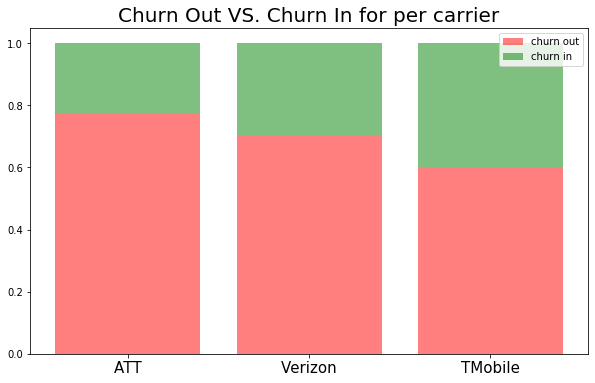

In [378]:
import matplotlib.pyplot as plt
x_carrier = ['ATT','Verizon','TMobile']
churn_out_percent = []
churn_in_percent = []
churn_out_percent.append(att_move_out/(att_move_out+att_move_in))
churn_in_percent.append(att_move_in/(att_move_out+att_move_in))
churn_out_percent.append(ver_move_out/(ver_move_out+ver_move_in))
churn_in_percent.append(ver_move_in/(ver_move_out+ver_move_in))
churn_out_percent.append(tmo_move_out/(tmo_move_out+tmo_move_in))
churn_in_percent.append(tmo_move_in/(tmo_move_out+tmo_move_in))


plt.figure(figsize=(10,6))
p1 = plt.bar(x_carrier, churn_out_percent, color='r',label='churn out',alpha=0.5)
p2 = plt.bar(x_carrier, churn_in_percent, bottom=churn_out_percent, color='g', label='churn in',alpha=0.5)
plt.legend()
plt.xticks(fontsize=15)
plt.title('Churn Out VS. Churn In for per carrier', fontsize=20)
plt.show()

In [379]:
import numpy as np

def drawPlot(neg, pos, name, title):
    bar_width = 0.3
    x = np.arange(len(name))
    plt.figure(figsize=(20, 8))
    plt.bar(x+bar_width/2, neg, width=bar_width, label="Churn Out", color='r', alpha=0.5)
    plt.bar(x+bar_width*1.5, pos, width=bar_width, label="Churn In", color='g', alpha=0.5)
    
    plt.legend(loc=0,fontsize=15)
    plt.xticks(x+bar_width, name, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize=20)
    plt.grid(alpha=0.2)
    plt.ylabel('percentage',fontsize=20)
    
#     x_text = list(x)+list(x+bar_width)
#     y_text = neg + pos
#     for a,b in zip(x_text,y_text):
#         plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
    plt.show()

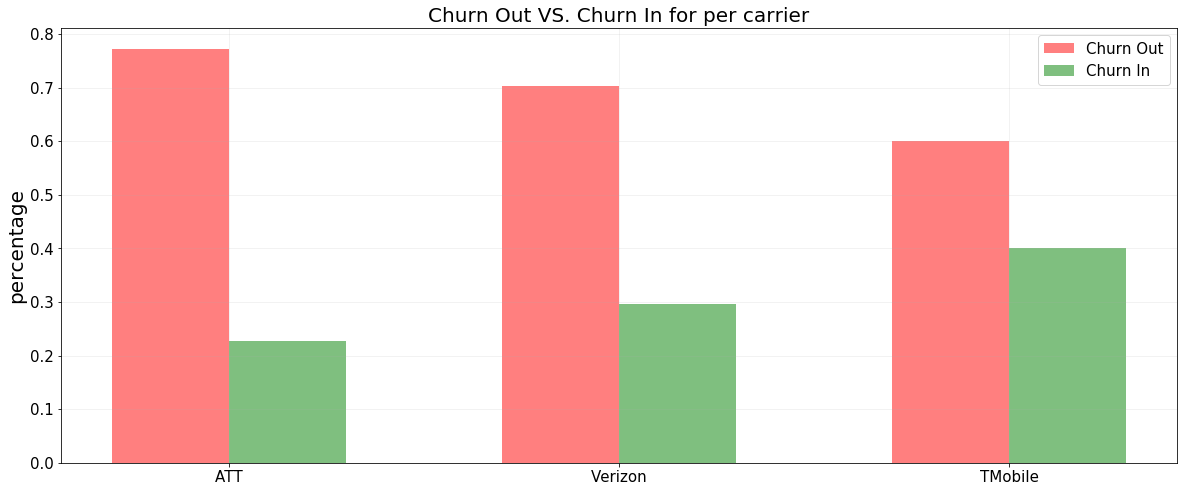

In [380]:
drawPlot(churn_out_percent, churn_in_percent, x_carrier, 'Churn Out VS. Churn In for per carrier')

### Составить словарь причин оттока

In [381]:

att_move_reason_text = ' '.join(att_move_reason)
ver_move_reason_text = ' '.join(ver_move_reason)
tmo_move_reason_text = ' '.join(tmo_move_reason)

In [382]:
import nltk

# Corpus processing and cleanning
def cleanCorpusNLTK(corpus):
    # get words list
    words = nltk.tokenize.word_tokenize(corpus)
    # filter out non-alphabet value
    words = [w for w in words if w.isalpha()]
    # filter out the words that is less than 2 char, such as 'I'
    words = [w for w in words if len(w) > 2]
    # lower all alphabet 
    words = [w.lower() for w in words]
    # filter out 'amp'(&amp), 'u'(you), and 'http'
    words = [w for w in words if w not in ['amp', 'u', 'http', 'https', 'att', 'verizon', 'tmobile']]
    # filter out stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = [w for w in words if w not in stop_words]
    # imporve linguistic ability in case of overstemming
    wordnet = nltk.stem.WordNetLemmatizer()
    lemmatized = [wordnet.lemmatize(w) for w in words]
    return lemmatized

In [383]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def drawWordCloud(corpus):
    if len(corpus)!=0:
        text_corpus = ' '.join(cleanCorpusNLTK(corpus))
        wordcloud = WordCloud(width=500, height=500, background_color='white', 
                    min_font_size =12).generate(text_corpus)
        plt.imshow(wordcloud)
    else:
        return 'no words'

Why people wants to churn from their original carrier?


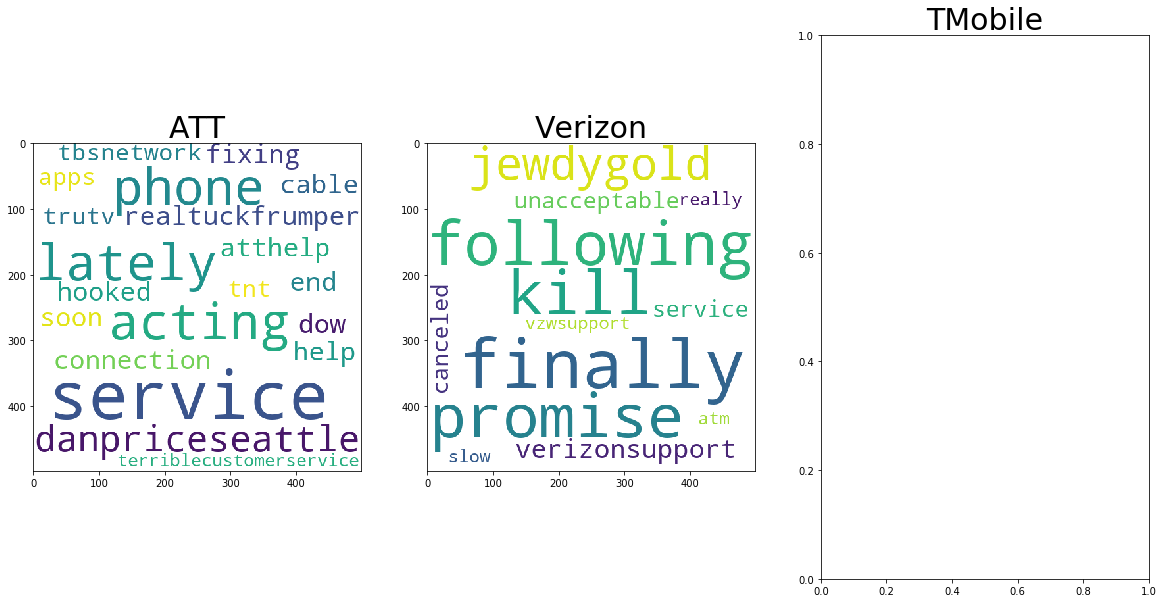

In [384]:
print('Why people wants to churn from their original carrier?')
plt.figure(figsize=(20,10))
plt.subplot(131)
drawWordCloud(att_move_reason_text)
plt.title('ATT', fontsize=30)
plt.subplot(132)
drawWordCloud(ver_move_reason_text)
plt.title('Verizon', fontsize=30)
plt.subplot(133)
drawWordCloud(tmo_move_reason_text)
plt.title('TMobile', fontsize=30)
plt.show()

### Составить словарь "предложений по улучшению для операторов"

In [385]:

def readReasons(move_reason):
    for m in move_reason:
        print(m,'\n')

In [386]:
readReasons(att_move_reason)

ATT service has been ASS lately or is it just my phone that’s been acting up? 

@DanPriceSeattle @realTuckFrumper I’m fixing to end my connection with at&amp;t as soon as I can get cable hooked up fo… https://t.co/eVwUqhbogg 

@ATTHelp my service is Dow can you help 

it’s also the @TBSNetwork TNT and @truTV apps also… https://t.co/SPi80zDJiq 

#att #terriblecustomerservice #Wireles… 



In [387]:
readReasons(ver_move_reason)

@JewdyGold @VerizonSupport Unacceptable, which is why I canceled my service with Verizon. 

#Verizon is finally following through on its promise to kill 3G https://t.co/5kOCVjvdoi 

Verizon is finally following through on its promise to kill 3G https://t.co/cAR1mKLYSc 

@VZWSupport It’s really slow atm 



In [388]:
readReasons(tmo_move_reason)